# Recreating baseline models

>Garcia-Ceja, E., Riegler, M., Jakobsen, P., Tørresen, J., Nordgreen, T., Oedegaard, K.J. and Fasmer, O.B. (2018) Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In: Proceedings of the 9th ACM Multimedia Systems Conference [online]MMSys ’18: 9th ACM Multimedia Systems Conference. Amsterdam Netherlands: ACM, pp. 472–477. Available from: https://dl.acm.org/doi/10.1145/3204949.3208125 [Accessed 2 December 2023].

**Objective**

* Recreating baseline models in the above article

**Files**

* [working-file: petter/baseline-garcia-working.ipynb](/petter/baseline-garcia-working.ipynb)
  * This file contains scrappy code and various bits and pieces
* [previous file - data extraction & eda](/petter/baseline-garcia-1-EDA.ipynb)
  * file contains data extraction and replicated EDA
  * saves data as csv for next file to pick up modelling
* [current file - baseline models](/petter/baseline-garcia-2-model.ipynb)

Outputs to be replicated: 

![garcia-weighted-average-classification-performance](./_images/2024-03-09-15-07-57.png)

## Import csv to dataframe

In [1]:
import pandas as pd

# filepath
garcia_full_scoreNum = '../data/petter/baseline-garcia-full-scoreNum.csv'

# import file
df = pd.read_csv(garcia_full_scoreNum, parse_dates=['date', 'timestamp'])

# print first 5 rows
print(df.head())


            timestamp       date  activity         id  label
0 2003-03-19 00:00:00 2003-03-19         0  control_1      0
1 2003-03-19 00:01:00 2003-03-19         0  control_1      0
2 2003-03-19 00:02:00 2003-03-19         0  control_1      0
3 2003-03-19 00:03:00 2003-03-19         0  control_1      0
4 2003-03-19 00:04:00 2003-03-19       175  control_1      0


## Features

"Each day was characterized by a feature vector which was computed by extracting a set of features on a per day basis from the activity level. The extracted features were the mean activity level, the corresponding standard deviation and the percentage of events with no activity i.e, activity level = 0. The features were normalized between 0 and 1 before the classification." (Garcia-Ceja et al., 2018)

So...

* We need a 'feature vector' by day with:
  * `mean activity level`
  * `standard deviation`
  * `percentage of events with no activity`
* Normalise the features between 0 and 1

Steps to create feature vector: 

1. group by date, id
2. calculate new features by grouped rows
3. join with original df for label, etc.
4. normalise new features
5. drop timestamp, activity 
6. remove duplicates to keep day features

In [2]:
import pandas as pd

# group data by date and id
grouped = df.groupby(['date', 'id'])

# features for each date-id combination - mean, std, and percentage of zeros
features = grouped['activity'].agg(['mean', 'std', lambda x: (x == 0).mean()])
features.columns = ['mean_activity', 'std_activity', 'pct_no_activity']

# reset index to make it a regular dataframe
features = features.reset_index()

# join with the original dataframe to get the labels
df_with_features = df.merge(features, on=['date', 'id'], how='left')

# normalise the features between 0 and 1
df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']] = (
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']] - 
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].min()) / (
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].max() - 
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].min())

# drop unnecessary columns
df_processed = df_with_features.drop(['timestamp', 'activity'], axis=1)

# remove duplicate rows
df_processed = df_processed.drop_duplicates()

## Train / Test Split

The new dataframe can be split into `train` and `test` NumPy arrays.

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# separate features and labels
X = df_processed[['mean_activity', 'std_activity', 'pct_no_activity']].values
y = df_processed['label'].values

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# shape of arrays
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(554, 3) (139, 3) (554,) (139,)


## Model

### Import libraries

In [9]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# cross validation
from sklearn.model_selection import cross_val_score

# metrics
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix, classification_report


### Create ZeroRClassifier

In [11]:
from collections import Counter

class ZeroRClassifier:
    """
    ZeroRClassifier is a simple classifier that always predicts the majority class in the training data.
    """
    def fit(self, X, y):
        """
        Fit the ZeroRClassifier to the training data.

        Parameters:
        - X: The input features of shape (n_samples, n_features).
        - y: The target labels of shape (n_samples,).

        Returns:
        - None
        """
        # find the majority class
        self.majority_class = Counter(y).most_common(1)[0][0]
        
    def predict(self, X):
        """
        Predict the class labels for the input data.

        Parameters:
        - X: The input features of shape (n_samples, n_features).

        Returns:
        - y_pred: The predicted class labels of shape (n_samples,).
        """
        # return the majority class for all samples
        return [self.majority_class] * len(X)

### Model Selection

In [17]:
models = [
    ('ZeroR', ZeroRClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Linear SVC', LinearSVC(dual=False, max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier(max_iter=1000)),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier(algorithm='SAMME')),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier()), 
    ('SVM rbf', SVC(kernel='rbf')),
    ('SVM linear', SVC(kernel='linear')),
    ('Gaussian Process', GaussianProcessClassifier())
]

models_2 = [
    ('Random Forest', RandomForestClassifier()),
    ('Linear SVC', LinearSVC(dual=False, max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier(max_iter=1000)),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier(algorithm='SAMME')),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier()), 
    ('SVM rbf', SVC(kernel='rbf')),
    ('SVM linear', SVC(kernel='linear')),
    ('Gaussian Process', GaussianProcessClassifier())
]

### Evaluate model v1 - basic, single run

* single run, store various metrics in a dictionary

In [12]:
def evaluate_models_v1(X_train, X_test, y_train, y_test, models):
    """
    Evaluate multiple models using various metrics and return the results.

    Args:
    - X_train (array-like): Training data features.
    - X_test (array-like): Testing data features.
    - y_train (array-like): Training data labels.
    - y_test (array-like): Testing data labels.
    - models (dict): Dictionary of model names and corresponding model objects.

    Returns:
    - results (dict): Dictionary containing evaluation results for each model.
        The keys are the model names and the values are dictionaries containing
        the following metrics:
        - elapsed_time: Time taken to fit the model.
        - accuracy: Accuracy score.
        - precision: Precision score.
        - recall: Recall score.
        - f1: F1 score.
        - specificity: Specificity score.
        - mcc: Matthews correlation coefficient.
        - cm: Confusion matrix.
        - cr: Classification report.
        - roc_auc: ROC AUC score.
    """
    # results dictionary
    results = {}
    
    # fit and time models
    for model_name, model in models:
        start_time = time.time()
        model.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        
        y_pred = model.predict(X_test)
        
        # calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = recall_score(y_test, y_pred, pos_label=0)
        mcc = matthews_corrcoef(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)
        
        # calculate roc auc
        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except (AttributeError, IndexError):
            y_pred_proba = y_pred
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # save results
        results[model_name] = {
            'elapsed_time': elapsed_time,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'specificity': specificity,
            'mcc': mcc,
            'cm': cm,
            'cr': cr,
            'roc_auc': roc_auc
        }
        
    return results

In [18]:
# version 1 - simplest
results_v1 = evaluate_models_v1(X_train, X_test, y_train, y_test, models)

# make into a dataframe
df_results = pd.DataFrame.from_dict(results_v1, orient='index')

c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Use

[LightGBM] [Info] Number of positive: 240, number of negative: 314
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 554, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433213 -> initscore=-0.268754
[LightGBM] [Info] Start training from score -0.268754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [19]:
# results into table
v1 = df_results[['elapsed_time', 'accuracy', 'precision', 'recall', 'f1', 'specificity','mcc', 'roc_auc']]
print(v1)


                     elapsed_time  accuracy  precision    recall        f1  \
ZeroR                    0.000000  0.633094   0.000000  0.000000  0.000000   
Random Forest            0.125225  0.741007   0.659574  0.607843  0.632653   
Linear SVC               0.001000  0.719424   0.615385  0.627451  0.621359   
Decision Tree            0.002517  0.683453   0.561404  0.627451  0.592593   
Logistic Regression      0.002002  0.719424   0.620000  0.607843  0.613861   
KNN                      0.001505  0.733813   0.620690  0.705882  0.660550   
Naive Bayes              0.000000  0.741007   0.627119  0.725490  0.672727   
Neural Network           0.854221  0.712230   0.617021  0.568627  0.591837   
XGBoost                  0.047195  0.733813   0.634615  0.647059  0.640777   
LightGBM                 0.037048  0.712230   0.600000  0.647059  0.622642   
AdaBoost                 0.084203  0.741007   0.653061  0.627451  0.640000   
QDA                      0.000000  0.776978   0.666667  0.784314

The results are not the same as those by Garcia et. al but they are not far off, for example: 

* Garcia's best performing baseline model is `Linear SVM` with `accuracy` = $0.727$, `mcc` = $0.433$ and `F1` = $0.724$
* In comparison, the `SVM linear` above has `accuracy` = $0.727$, `mcc` = $0.398$ and `F1` = $0.604$

It is important to bear in mind that Garcia's baseline models are weighted averages over 10 runs.

The overall best model in the recreation is QDA.

In [55]:
def print_best_models(df_results):
    """
    Print the best model for each metric based on the results dataframe.

    Args:
    - df_results (pd.DataFrame): DataFrame containing the evaluation results.

    Returns:
    - None
    """
    print('Best model for each metric:')
    print('Accuracy:', df_results['accuracy'].idxmax())
    print('Precision:', df_results['precision'].idxmax())
    print('Recall:', df_results['recall'].idxmax())
    print('F1:', df_results['f1'].idxmax())
    print('Specificity:', df_results['specificity'].idxmax())
    print('MCC:', df_results['mcc'].idxmax())
    print('ROC AUC:', df_results['roc_auc'].idxmax())
    print('Elapsed Time:', df_results['elapsed_time'].idxmin())


In [56]:
print_best_models(df_results)

Best model for each metric:
Accuracy: QDA
Precision: QDA
Recall: QDA
F1: QDA
Specificity: ZeroR
MCC: QDA
ROC AUC: QDA
Elapsed Time: ZeroR


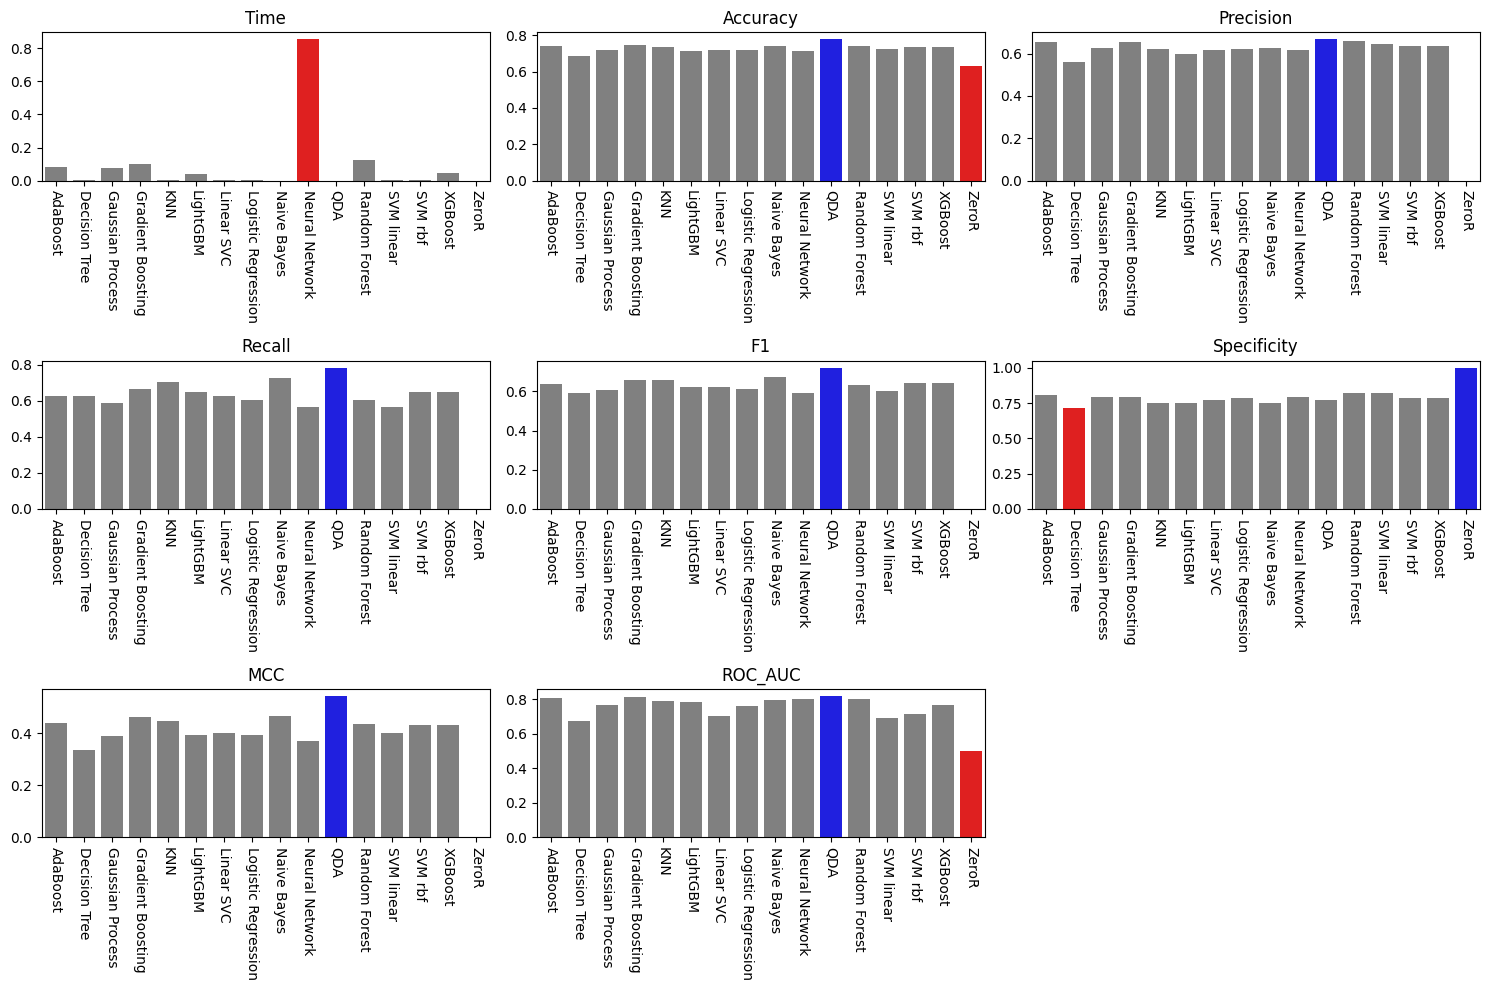

In [33]:

import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# List of metrics
metrics = ['elapsed_time', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'mcc', 'roc_auc']
labels = ['Time', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity', 'MCC', 'ROC_AUC']

# plot metrics
for i, metric in enumerate(metrics):
    row = i // 3  # integer division to convert i into a row index
    col = i % 3  # modulo division to convert i into a column index
    ax = axs[row, col]
    df_sorted = v1.sort_index()  # sort the DataFrame by index
    
    # index of the highest and lowest value for the current metric
    max_index = df_sorted[metric].idxmax()
    min_index = df_sorted[metric].idxmin()
    
    # list of colors for each bar
    if metric == 'elapsed_time':
        colors = ['red' if index == max_index else 'blue' if index == min_index else 'gray' for index in df_sorted.index]
    else:
        colors = ['blue' if index == max_index else 'red' if index == min_index else 'gray' for index in df_sorted.index]
    
    # plot the bar chart
    sns.barplot(data=df_sorted, x=df_sorted.index, y=metric, ax=ax, palette=colors, hue=df_sorted.index)  
    ax.set_xticks(range(len(df_sorted.index)))  # set the ticks explicitly
    ax.set_xticklabels(df_sorted.index, rotation=90)  # set x-tick labels to the names in the sorted df
    # rotate x axis labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(270)

    ax.set_title(labels[i]) # set the title of the subplot
    ax.set_xlabel('')
    ax.set_ylabel('')

# remove unused plots
for i in range(len(metrics), len(axs.flatten())):
    axs.flatten()[i].remove()

plt.tight_layout()
plt.show()


#### Confusion Matrices

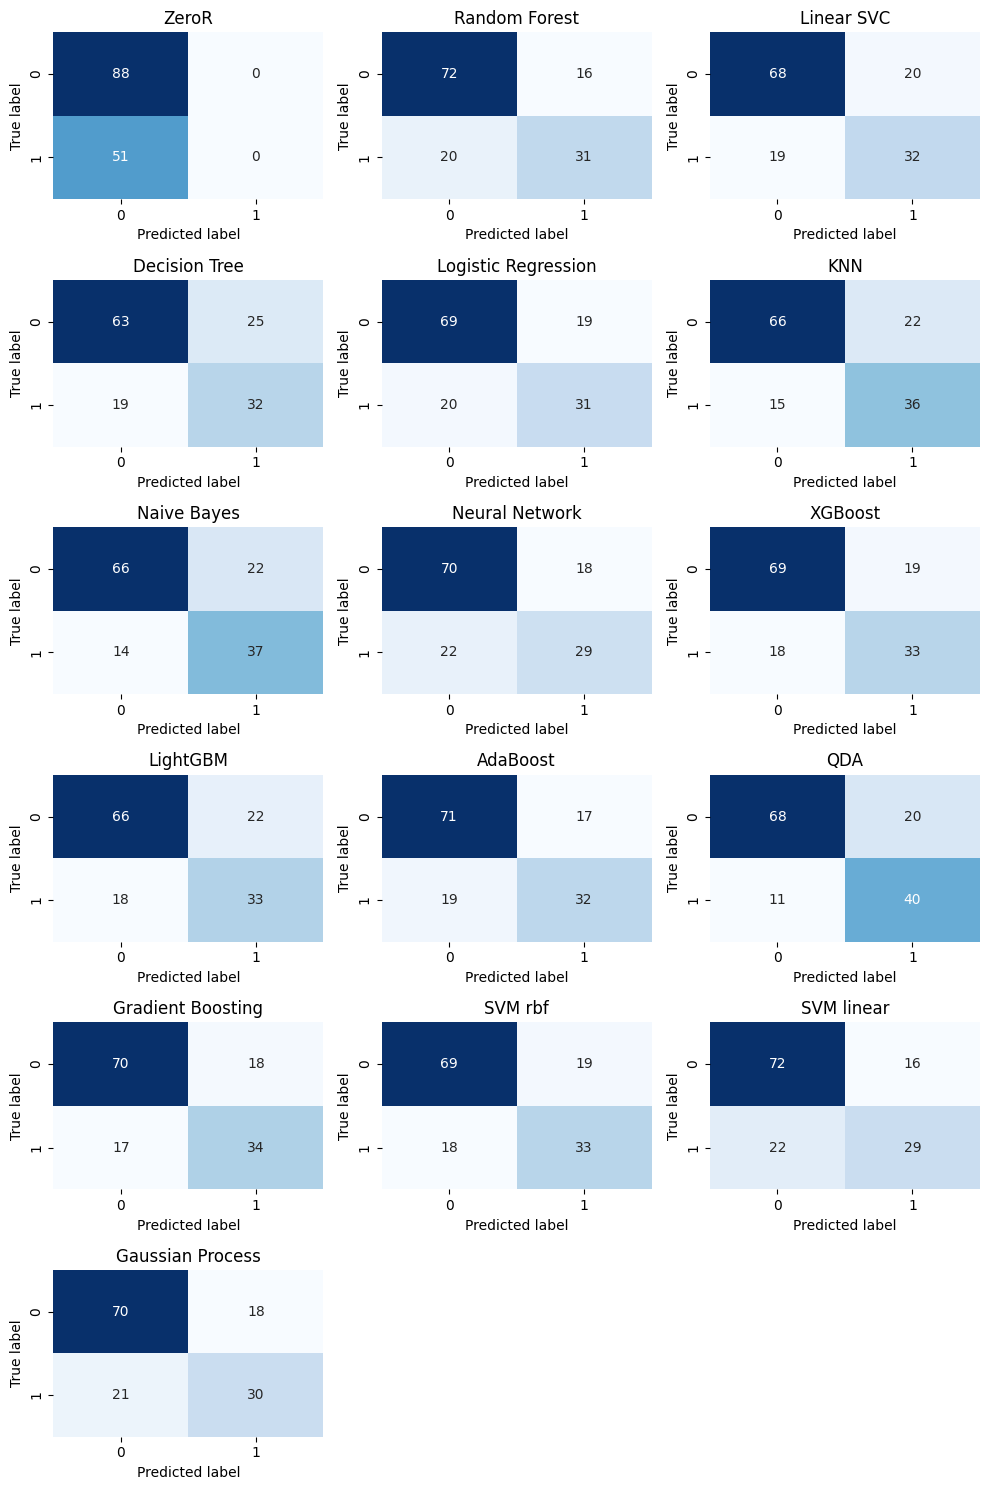

In [39]:
# print confusion matrix
#print(df_results['cm'])

# plot confusion matrix for each model
num_models = len(results_v1) # number of models
num_cols = 3 # number of columns in the plot grid
num_rows = (num_models + num_cols - 1) // num_cols # integer division to get the number of rows

# create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 15))

# plot confusion matrix for each model
for i, (model_name, model_results) in enumerate(results_v1.items()):
    row = i // num_cols # integer division to convert i into a row index
    col = i % num_cols # modulo division to convert i into a column index
    cm = model_results['cm']
    ax = axs[row, col]
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

# emove unused subplots
for i in range(num_models, num_rows * num_cols):
    axs.flatten()[i].remove()

plt.tight_layout()
plt.show()


### Evaluate model v2

* cross validation option
* takes whole dataset (X, y)

In [51]:
def evaluate_models_v2(X_train, X_test, y_train, y_test, models, cv=1):
    """
    Evaluate multiple models using various metrics and return the results.

    Args:
        - X_train (array-like): Training data features.
        - X_test (array-like): Testing data features.
        - y_train (array-like): Training data labels.
        - y_test (array-like): Testing data labels.
        - models (dict): Dictionary of model names and corresponding model objects.
        - cv (int): Number of times to run the models and average the results.

    Returns:
        - results (dict): Dictionary containing evaluation results for each model.
          The keys are the model names and the values are dictionaries containing
          the following metrics (averaged over `cv` runs):
            - elapsed_time: Time taken to fit the model.
            - accuracy: Accuracy score.
            - precision: Precision score.
            - recall: Recall score.
            - f1: F1 score.
            - specificity: Specificity score.
            - mcc: Matthews correlation coefficient.
            - roc_auc: ROC AUC score.
    """
    results = {}

    for model_name, model in models:
        model_results = []

        for _ in range(cv):
            start_time = time.time()
            model.fit(X_train, y_train)
            elapsed_time = time.time() - start_time

            y_pred = model.predict(X_test)

            # calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            specificity = recall_score(y_test, y_pred, pos_label=0)
            mcc = matthews_corrcoef(y_test, y_pred)

            try:
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            except (AttributeError, IndexError):
                y_pred_proba = y_pred
                roc_auc = roc_auc_score(y_test, y_pred_proba)

            model_results.append({
                'elapsed_time': elapsed_time,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'specificity': specificity,
                'mcc': mcc,
                'roc_auc': roc_auc
            })

        # compute averages
        averaged_results = {}
        for metric in model_results[0].keys():
            averaged_results[metric] = sum(result[metric] for result in model_results) / cv

        results[model_name] = averaged_results

    return results

In [52]:
results_v2 = evaluate_models_v2(X_train, X_test, y_train, y_test, models, cv=10)

c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anacond

[LightGBM] [Info] Number of positive: 240, number of negative: 314
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 554, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433213 -> initscore=-0.268754
[LightGBM] [Info] Start training from score -0.268754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [54]:
# make into a dataframe
df_results_2 = pd.DataFrame.from_dict(results_v2, orient='index')
# results
v2 = df_results_2[['elapsed_time', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'mcc', 'roc_auc']]
print(v2)

                     elapsed_time  accuracy  precision    recall        f1  \
ZeroR                    0.000298  0.633094   0.000000  0.000000  0.000000   
Random Forest            0.104595  0.733813   0.643495  0.617647  0.629938   
Linear SVC               0.001061  0.719424   0.615385  0.627451  0.621359   
Decision Tree            0.001761  0.670504   0.544369  0.627451  0.582924   
Logistic Regression      0.001618  0.719424   0.620000  0.607843  0.613861   
KNN                      0.000403  0.733813   0.620690  0.705882  0.660550   
Naive Bayes              0.000506  0.741007   0.627119  0.725490  0.672727   
Neural Network           0.620892  0.719424   0.624560  0.590196  0.606689   
XGBoost                  0.051467  0.733813   0.634615  0.647059  0.640777   
LightGBM                 0.031044  0.712230   0.600000  0.647059  0.622642   
AdaBoost                 0.055497  0.741007   0.653061  0.627451  0.640000   
QDA                      0.000501  0.776978   0.666667  0.784314

In [57]:
# print best models
print_best_models(df_results_2)

Best model for each metric:
Accuracy: QDA
Precision: QDA
Recall: QDA
F1: QDA
Specificity: ZeroR
MCC: QDA
ROC AUC: QDA
Elapsed Time: ZeroR


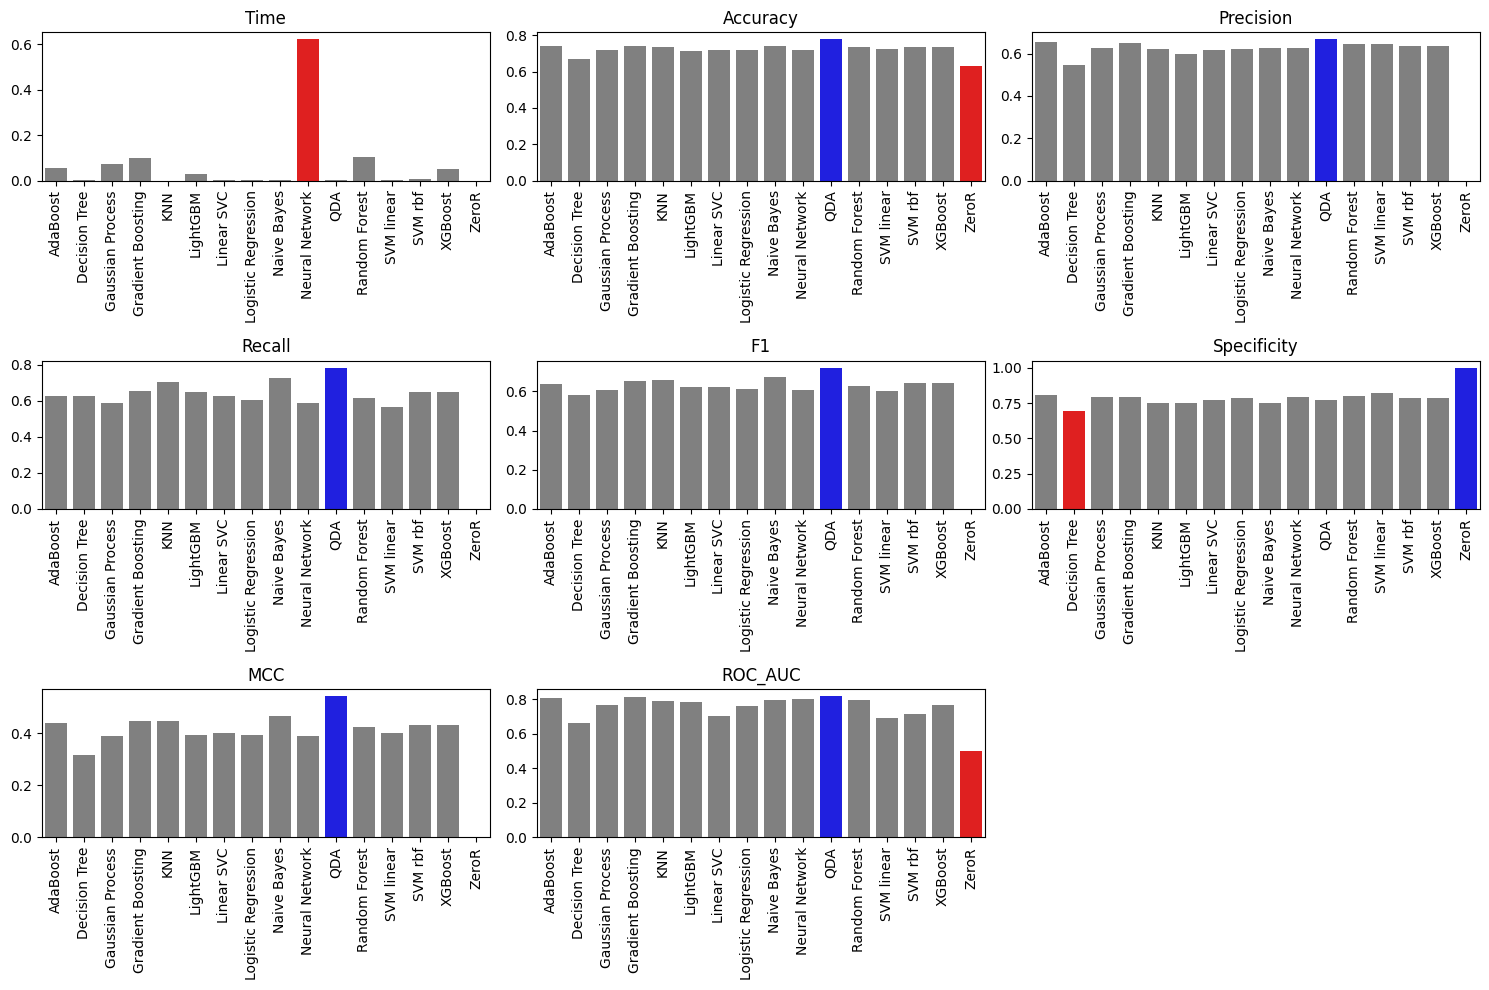

In [59]:

import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# List of metrics
metrics = ['elapsed_time', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'mcc', 'roc_auc']
labels = ['Time', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity', 'MCC', 'ROC_AUC']

# plot metrics
for i, metric in enumerate(metrics):
    row = i // 3  # integer division to convert i into a row index
    col = i % 3  # modulo division to convert i into a column index
    ax = axs[row, col]
    df_sorted = v2.sort_index()  # sort the DataFrame by index
    
    # index of the highest and lowest value for the current metric
    max_index = df_sorted[metric].idxmax()
    min_index = df_sorted[metric].idxmin()
    
    # list of colors for each bar
    if metric == 'elapsed_time':
        colors = ['red' if index == max_index else 'blue' if index == min_index else 'gray' for index in df_sorted.index]
    else:
        colors = ['blue' if index == max_index else 'red' if index == min_index else 'gray' for index in df_sorted.index]
    
    sns.barplot(data=df_sorted, x=df_sorted.index, y=metric, ax=ax, palette=colors, hue=df_sorted.index)  
    ax.set_xticks(range(len(df_sorted.index)))  # set the ticks explicitly
    ax.set_xticklabels(df_sorted.index, rotation=90)  # set x-tick labels to the names in the sorted df
    ax.set_title(labels[i])  # modified line
    ax.set_xlabel('')
    ax.set_ylabel('')

# remove unused plots
for i in range(len(metrics), len(axs.flatten())):
    axs.flatten()[i].remove()

plt.tight_layout()
plt.show()


### Evaluate model v3

* Metrics for each class

In [60]:


def evaluate_models_v3(X_train, X_test, y_train, y_test, models):
    # results dictionary
    results = {}

    # fit and time models
    for model_name, model in models:
        start_time = time.time()
        model.fit(X_train, y_train)
        elapsed_time = time.time() - start_time

        y_pred = model.predict(X_test)

        # calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True)

        # calculate roc auc
        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except (AttributeError, IndexError):
            y_pred_proba = y_pred
            roc_auc = roc_auc_score(y_test, y_pred_proba)

        # calculate metrics for each class
        class_metrics = []
        tn_sum = 0
        fp_sum = 0
        for cls in np.unique(y):
            precision = class_report[str(cls)]['precision']
            recall = class_report[str(cls)]['recall']
            f1 = class_report[str(cls)]['f1-score']
            tn, fp, fn, tp = conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[1, 1]
            specificity = tn / (tn + fp)
            mcc = matthews_corrcoef(y_test, y_pred, sample_weight=None)
            class_metrics.append({
                'class': cls,
                'precision': precision,
                'recall': recall,
                'accuracy': accuracy,
                'specificity': specificity,
                'mcc': mcc,
                'f1': f1
            })
            tn_sum += tn
            fp_sum += fp

        weighted_specificity = tn_sum / (tn_sum + fp_sum)

        weighted_metrics = {
            'precision': class_report['weighted avg']['precision'],
            'recall': class_report['weighted avg']['recall'],
            'accuracy': accuracy,
            'specificity': weighted_specificity,
            'mcc': mcc,
            'f1': class_report['weighted avg']['f1-score']
        }

        results[model_name] = {
            'elapsed_time': elapsed_time,
            'class_metrics': class_metrics,
            'weighted_metrics': weighted_metrics,
            'conf_matrix': conf_matrix,
            'roc_auc': roc_auc
        }


    return results

In [61]:
results_v3 = evaluate_models_v3(X_train, X_test, y_train, y_test, models)

c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

[LightGBM] [Info] Number of positive: 240, number of negative: 314
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 554, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433213 -> initscore=-0.268754
[LightGBM] [Info] Start training from score -0.268754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [62]:
# print key values for first model
print('Elapsed Time:', results_v3['Random Forest']['elapsed_time'])
print('Class Metrics:', results_v3['Random Forest']['class_metrics'])
print('Weighted Metrics:', results_v3['Random Forest']['weighted_metrics'])
print('Confusion Matrix:', results_v3['Random Forest']['conf_matrix'])
print('ROC AUC:', results_v3['Random Forest']['roc_auc'])


Elapsed Time: 0.11040997505187988
Class Metrics: [{'class': 0, 'precision': 0.7789473684210526, 'recall': 0.8409090909090909, 'accuracy': 0.7482014388489209, 'specificity': 0.8409090909090909, 'mcc': 0.4446739802359958, 'f1': 0.8087431693989071}, {'class': 1, 'precision': 0.6818181818181818, 'recall': 0.5882352941176471, 'accuracy': 0.7482014388489209, 'specificity': 0.8409090909090909, 'mcc': 0.4446739802359958, 'f1': 0.631578947368421}]
Weighted Metrics: {'precision': 0.7433100409624454, 'recall': 0.7482014388489209, 'accuracy': 0.7482014388489209, 'specificity': 0.8409090909090909, 'mcc': 0.4446739802359958, 'f1': 0.7437404692294481}
Confusion Matrix: [[74 14]
 [21 30]]
ROC AUC: 0.8020276292335116


In [63]:
def extract_results(results):
    rows = []
    for model_name, model_results in results.items():
        elapsed_time = model_results['elapsed_time']
        class_metrics = model_results['class_metrics']
        weighted_metrics = model_results['weighted_metrics']
        roc_auc = model_results['roc_auc']

        for cls_metrics in class_metrics:
            row = [
                model_name,
                cls_metrics['class'],
                cls_metrics['precision'],
                cls_metrics['recall'],
                cls_metrics['accuracy'],
                cls_metrics['specificity'],
                cls_metrics['mcc'],
                cls_metrics['f1'],
                roc_auc,
                elapsed_time  # Added elapsed_time here
            ]
            rows.append(row)

        weighted_row = [
            model_name,
            'weighted_avg',
            weighted_metrics['precision'],
            weighted_metrics['recall'],
            weighted_metrics['accuracy'],
            weighted_metrics['specificity'],
            weighted_metrics['mcc'],
            weighted_metrics['f1'],
            roc_auc,
            elapsed_time  # Added elapsed_time here
        ]
        rows.append(weighted_row)

    columns = ['Classifier', 'Class', 'Precision', 'Recall', 'Accuracy', 'Specificity', 'MCC', 'F1', 'ROC-AUC', 'Elapsed_Time']
    df = pd.DataFrame(rows, columns=columns)
    return df

In [64]:
# extract results
df_results_3 = extract_results(results_v3)
print(df_results_3)

             Classifier         Class  Precision    Recall  Accuracy  \
0                 ZeroR             0   0.633094  1.000000  0.633094   
1                 ZeroR             1   0.000000  0.000000  0.633094   
2                 ZeroR  weighted_avg   0.400807  0.633094  0.633094   
3         Random Forest             0   0.778947  0.840909  0.748201   
4         Random Forest             1   0.681818  0.588235  0.748201   
5         Random Forest  weighted_avg   0.743310  0.748201  0.748201   
6            Linear SVC             0   0.781609  0.772727  0.719424   
7            Linear SVC             1   0.615385  0.627451  0.719424   
8            Linear SVC  weighted_avg   0.720620  0.719424  0.719424   
9         Decision Tree             0   0.762500  0.693182  0.669065   
10        Decision Tree             1   0.542373  0.627451  0.669065   
11        Decision Tree  weighted_avg   0.681734  0.669065  0.669065   
12  Logistic Regression             0   0.775281  0.784091  0.71

In [65]:
# print svm linear
print(df_results_3[df_results_3['Classifier'] == 'SVM linear'])


    Classifier         Class  Precision    Recall  Accuracy  Specificity  \
42  SVM linear             0   0.765957  0.818182  0.726619     0.818182   
43  SVM linear             1   0.644444  0.568627  0.726619     0.818182   
44  SVM linear  weighted_avg   0.721374  0.726619  0.726619     0.818182   

         MCC        F1   ROC-AUC  Elapsed_Time  
42  0.398431  0.791209  0.693405      0.004536  
43  0.398431  0.604167  0.693405      0.004536  
44  0.398431  0.722582  0.693405      0.004536  


In [67]:
# print qda
print(df_results_3[df_results_3['Classifier'] == 'QDA'])


   Classifier         Class  Precision    Recall  Accuracy  Specificity  \
33        QDA             0   0.860759  0.772727  0.776978     0.772727   
34        QDA             1   0.666667  0.784314  0.776978     0.772727   
35        QDA  weighted_avg   0.789546  0.776978  0.776978     0.772727   

         MCC        F1   ROC-AUC  Elapsed_Time  
33  0.542031  0.814371  0.817736      0.001004  
34  0.542031  0.720721  0.817736      0.001004  
35  0.542031  0.780010  0.817736      0.001004  


### Evaluate Model v4 

* each class with cross-validation

In [69]:
def evaluate_models_v4(X_train, X_test, y_train, y_test, models, cv=1):
    """
    Evaluate multiple models using various metrics and return the results.

    Args:
        - X_train (array-like): Training data features.
        - X_test (array-like): Testing data features.
        - y_train (array-like): Training data labels.
        - y_test (array-like): Testing data labels.
        - models (dict): Dictionary of model names and corresponding model objects.
        - cv (int): Number of times to run the models and average the results.

    Returns:
        - results (dict): Dictionary containing evaluation results for each model.
          The keys are the model names and the values are dictionaries containing
          the following metrics (averaged over `cv` runs):
            - elapsed_time: Time taken to fit the model.
            - class_metrics: List of dictionaries containing metrics for each class.
            - weighted_metrics: Dictionary containing weighted average metrics.
            - conf_matrix: Confusion matrix.
            - roc_auc: ROC AUC score.
    """
    results = {}

    for model_name, model in models:
        model_results = []

        for _ in range(cv):
            start_time = time.time()
            model.fit(X_train, y_train)
            elapsed_time = time.time() - start_time

            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)
            class_report = classification_report(y_test, y_pred, output_dict=True)

            try:
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            except (AttributeError, IndexError):
                y_pred_proba = y_pred
                roc_auc = roc_auc_score(y_test, y_pred_proba)

            # calculate metrics for each class
            class_metrics = []
            tn_sum = 0
            fp_sum = 0
            for cls in np.unique(y):
                precision = class_report[str(cls)]['precision']
                recall = class_report[str(cls)]['recall']
                f1 = class_report[str(cls)]['f1-score']
                tn, fp, fn, tp = conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[1, 1]
                specificity = tn / (tn + fp)
                mcc = matthews_corrcoef(y_test, y_pred, sample_weight=None)
                class_metrics.append({
                    'class': cls,
                    'precision': precision,
                    'recall': recall,
                    'accuracy': accuracy,
                    'specificity': specificity,
                    'mcc': mcc,
                    'f1': f1
                })
                tn_sum += tn
                fp_sum += fp

            weighted_specificity = tn_sum / (tn_sum + fp_sum)
            weighted_metrics = {
                'precision': class_report['weighted avg']['precision'],
                'recall': class_report['weighted avg']['recall'],
                'accuracy': accuracy,
                'specificity': weighted_specificity,
                'mcc': mcc,
                'f1': class_report['weighted avg']['f1-score']
            }

            model_results.append({
                'elapsed_time': elapsed_time,
                'class_metrics': class_metrics,
                'weighted_metrics': weighted_metrics,
                'conf_matrix': conf_matrix,
                'roc_auc': roc_auc
            })

        # compute averages
        averaged_results = {}
        for metric in model_results[0].keys():
            if metric == 'class_metrics':
                averaged_class_metrics = []
                for i in range(len(model_results[0]['class_metrics'])):
                    class_metric = {}
                    for key in model_results[0]['class_metrics'][i].keys():
                        if key == 'class':
                            class_metric[key] = model_results[0]['class_metrics'][i][key]
                        else:
                            class_metric[key] = sum(result['class_metrics'][i][key] for result in model_results) / cv
                    averaged_class_metrics.append(class_metric)
                averaged_results['class_metrics'] = averaged_class_metrics
            elif metric == 'weighted_metrics':
                averaged_weighted_metrics = {}
                for key in model_results[0]['weighted_metrics'].keys():
                    averaged_weighted_metrics[key] = sum(result['weighted_metrics'][key] for result in model_results) / cv
                averaged_results['weighted_metrics'] = averaged_weighted_metrics
            elif metric == 'conf_matrix':
                averaged_conf_matrix = sum(result['conf_matrix'] for result in model_results) / cv
                averaged_results['conf_matrix'] = averaged_conf_matrix
            else:
                averaged_results[metric] = sum(result[metric] for result in model_results) / cv

        results[model_name] = averaged_results

    return results

In [71]:
# evaluate models
results_v4 = evaluate_models_v4(X_train, X_test, y_train, y_test, models, cv=10)

c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

[LightGBM] [Info] Number of positive: 240, number of negative: 314
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 554, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433213 -> initscore=-0.268754
[LightGBM] [Info] Start training from score -0.268754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [73]:
# extract results
df_results_4 = extract_results(results_v4)
print(df_results_4)

             Classifier         Class  Precision    Recall  Accuracy  \
0                 ZeroR             0   0.633094  1.000000  0.633094   
1                 ZeroR             1   0.000000  0.000000  0.633094   
2                 ZeroR  weighted_avg   0.400807  0.633094  0.633094   
3         Random Forest             0   0.781733  0.805682  0.734532   
4         Random Forest             1   0.646129  0.611765  0.734532   
5         Random Forest  weighted_avg   0.731979  0.734532  0.734532   
6            Linear SVC             0   0.781609  0.772727  0.719424   
7            Linear SVC             1   0.615385  0.627451  0.719424   
8            Linear SVC  weighted_avg   0.720620  0.719424  0.719424   
9         Decision Tree             0   0.762742  0.694318  0.669784   
10        Decision Tree             1   0.543528  0.627451  0.669784   
11        Decision Tree  weighted_avg   0.682311  0.669784  0.669784   
12  Logistic Regression             0   0.775281  0.784091  0.71

In [74]:
# print svm linear
print(df_results_4[df_results_4['Classifier'] == 'SVM linear'])

    Classifier         Class  Precision    Recall  Accuracy  Specificity  \
42  SVM linear             0   0.765957  0.818182  0.726619     0.818182   
43  SVM linear             1   0.644444  0.568627  0.726619     0.818182   
44  SVM linear  weighted_avg   0.721374  0.726619  0.726619     0.818182   

         MCC        F1   ROC-AUC  Elapsed_Time  
42  0.398431  0.791209  0.693405      0.004373  
43  0.398431  0.604167  0.693405      0.004373  
44  0.398431  0.722582  0.693405      0.004373  
